# Generating schema, baseline statistics and sample skewed data



## Setup

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_data_validation as tfdv

from tensorflow import io as tf_io

In [1]:
PROJECT = 'mlops-dev-env'
GCS_DATA_LOCATION = 'gs://workshop-datasets/covertype/data_validation'
REGION = 'us-central1'
LOCAL_WORKSPACE = './data_staging'
LOCAL_DATA_DIR = os.path.join(LOCAL_WORKSPACE, 'data')
LOCAL_DATA_FILE = os.path.join(LOCAL_DATA_DIR, 'train.csv')
MODEL_NAME = 'covertype_tf'
VERSION_NAME = 'v3'

GCS_WORKSPACE = 'gs://mlops-dev-workspace/drift-monitor'
LOCAL_SCHEMA_DIR = LOCAL_WORKSPACE + '/schema'
LOCAL_BASELINE_STATS_DIR = LOCAL_WORKSPACE + '/baseline_stats'
GCS_SCHEMA_LOCATION = GCS_WORKSPACE + '/schema'
GCS_BASELINE_STATS_LOCATION = GCS_WORKSPACE + '/baseline_stats'

In [3]:
!gcloud config set project {PROJECT}

Updated property [core/project].


## 1. Download Data

We use the [covertype](https://archive.ics.uci.edu/ml/datasets/covertype) from UCI Machine Learning Repository. The task is to Predict forest cover type from cartographic variables only. 

The dataset is preprocessed, split, and uploaded to uploaded to the `gs://workshop-datasets/covertype` public GCS location. 

We use this version of the preprocessed dataset in this notebook. For more information, see [Cover Type Dataset](https://github.com/GoogleCloudPlatform/mlops-on-gcp/tree/master/datasets/covertype)

In [4]:
if tf_io.gfile.exists(LOCAL_WORKSPACE):
  print("Removing previous workspace artifacts...")
  tf_io.gfile.rmtree(LOCAL_WORKSPACE)

print("Creating a new workspace...")
tf_io.gfile.makedirs(LOCAL_WORKSPACE)
tf_io.gfile.makedirs(LOCAL_DATA_DIR)
tf_io.gfile.makedirs(LOCAL_SCHEMA_DIR)
tf_io.gfile.makedirs(LOCAL_BASELINE_STATS_DIR)

Removing previous workspace artifacts...
Creating a new workspace...


In [5]:
!gsutil cp gs://workshop-datasets/covertype/data_validation/training/dataset.csv {LOCAL_DATA_FILE}
!wc -l {LOCAL_DATA_FILE}

Copying gs://workshop-datasets/covertype/data_validation/training/dataset.csv...

Operation completed over 1 objects/22.2 MiB.                                     
431010 ./data_staging/data/train.csv


In [6]:
import pandas as pd
data = pd.read_csv(LOCAL_DATA_FILE)
print("Total number of records: {}".format(len(data.index)))
data

Total number of records: 431009


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,3034,235,13,655,134,5799,197,251,190,4094,Rawah,7745,1
1,2827,26,16,85,13,3511,211,204,125,6008,Rawah,7745,1
2,2854,27,12,484,22,618,215,214,134,1295,Commanche,4704,1
3,3188,156,13,175,28,3666,235,241,134,1719,Commanche,7756,1
4,3091,61,8,134,10,1390,227,223,129,2868,Commanche,7202,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431004,3049,290,5,663,32,1380,206,239,172,787,Commanche,7101,1
431005,2776,43,13,60,-10,2737,222,212,122,2002,Commanche,7700,1
431006,2970,61,21,365,175,390,232,191,82,1377,Rawah,7745,0
431007,2975,7,10,272,76,3421,208,221,150,2056,Rawah,7745,1


## 2. Define Metadata

In [7]:
HEADER = ['Elevation', 'Aspect', 'Slope','Horizontal_Distance_To_Hydrology',
          'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
          'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
          'Cover_Type']

TARGET_FEATURE_NAME = 'Cover_Type'

FEATURE_LABELS = ['0', '1', '2', '3', '4', '5', '6']

NUMERIC_FEATURE_NAMES = ['Aspect', 'Elevation', 'Hillshade_3pm', 
                         'Hillshade_9am', 'Hillshade_Noon', 
                         'Horizontal_Distance_To_Fire_Points',
                         'Horizontal_Distance_To_Hydrology',
                         'Horizontal_Distance_To_Roadways','Slope',
                         'Vertical_Distance_To_Hydrology']

CATEGORICAL_FEATURE_NAMES = ['Soil_Type', 'Wilderness_Area']

FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES + NUMERIC_FEATURE_NAMES

HEADER_DEFAULTS = [[0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ['NA'] 
                   for feature_name in HEADER]

NUM_CLASSES = len(FEATURE_LABELS)

#### create a container for the serving data

In [8]:
serving_data = {
    '2020-04-01': None,
    '2020-04-02': None,
    '2020-04-03': None,
    '2020-04-04': None,
    '2020-04-05': None,
    '2020-04-06': None,
}

## 3. Sampling Unskewed Data

* Sample data for *three* consecutive dates: **01-04-20202**, **02-04-2020**, and **03-04-2020**
* Each day has 1000 examples
* No altering is applied



In [9]:
data_normal = data.sample(3000)

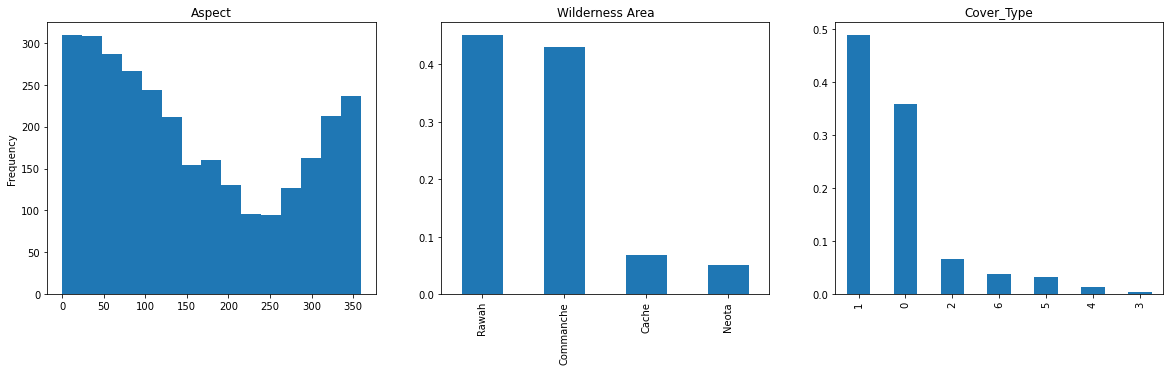

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
data_normal['Aspect'].plot.hist(bins=15, ax=axes[0], title='Aspect')
data_normal['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1], title='Wilderness Area')
data_normal[TARGET_FEATURE_NAME].value_counts(normalize=True).plot.bar(ax=axes[2], title=TARGET_FEATURE_NAME)

In [11]:
normal_days_data_list =[
                        data_normal[:1000],
                        data_normal[1000:2000],
                        data_normal[2000:]
]


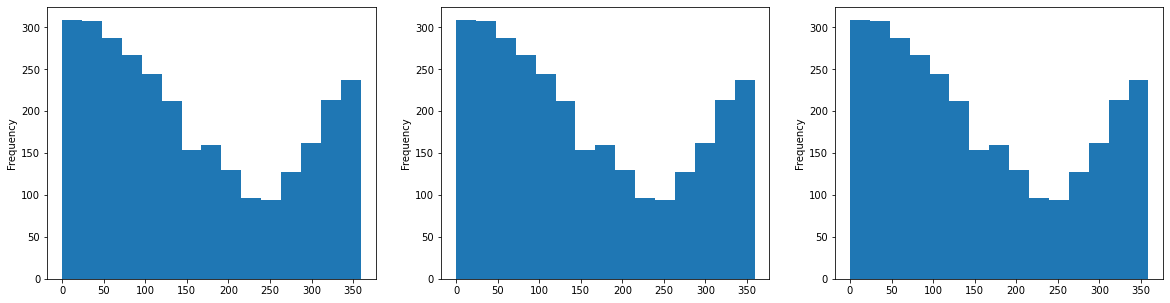

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal['Aspect'].plot.hist(bins=15, ax=axes[i])

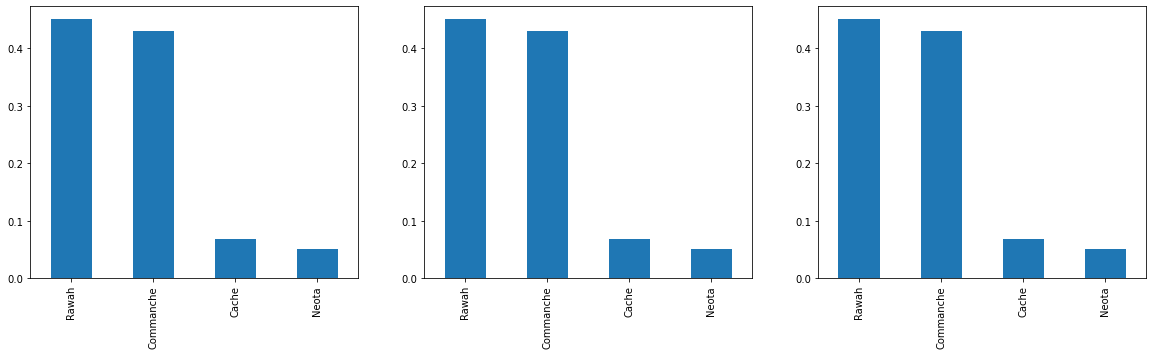

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[i])

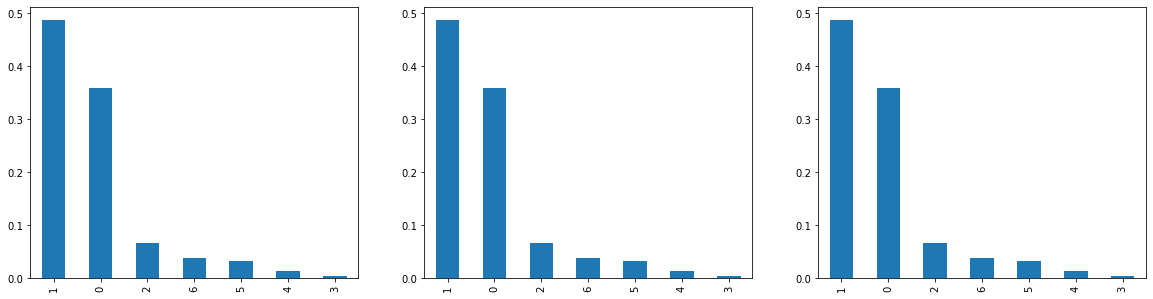

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal[TARGET_FEATURE_NAME].value_counts(normalize=True).plot.bar(ax=axes[i])

In [15]:
serving_data['2020-04-01'] = normal_days_data_list[0]
serving_data['2020-04-02'] = normal_days_data_list[1]
serving_data['2020-04-03'] = normal_days_data_list[2]

## 4. Preparing Skewed Data
We are going to introduce the following skews to the data:
1. **Numerical Features**
  1. *Elevation - Feature Skew*: Convert the unit of measure from meters to kilometers in 2020-04-05
  2. *Aspect - Distribution Skew*: gradual decrease of the value

2. **Categorical Features**
  1. *Wilderness_Area - Feature Skew*: Adding a new category "Others" in 2020-04-05
  2. *Wilderness_Area - Distribution Skew*: Gradual increase of of the frequency of "Cache" and "Neota" values
3. **Target Features**: check the change of the distribution of predictied class labels

In [16]:
data_to_skew = data.sample(3000)
serving_data['2020-04-04'] = data_to_skew[:1000]
serving_data['2020-04-05'] = data_to_skew[1000:2000]
serving_data['2020-04-06'] = data_to_skew[2000:]

### 4.1 Skew numerical features

#### 4.1.1 Elevation Feature Skew

In [17]:
serving_data['2020-04-05']['Elevation'] = serving_data['2020-04-05']['Elevation'] / 1000

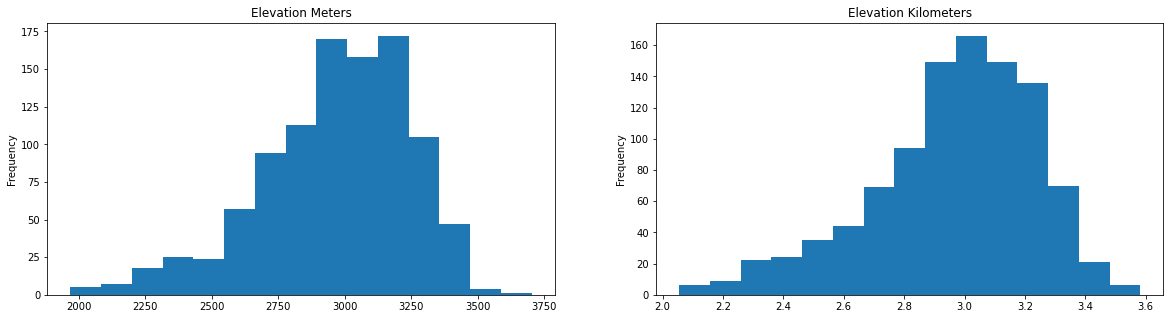

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
serving_data['2020-04-01']['Elevation'].plot.hist(bins=15, ax=axes[0], title='Elevation Meters')
serving_data['2020-04-05']['Elevation'].plot.hist(bins=15, ax=axes[1], title='Elevation Kilometers')

#### 4.1.2 Aspect Distribution Skew

In [19]:
serving_data['2020-04-04']['Aspect'] = serving_data['2020-04-04']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.90, 1) if value > 250 else value 
)

serving_data['2020-04-05']['Aspect'] = serving_data['2020-04-05']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.85, 1) if value > 250 else value 
)

serving_data['2020-04-06']['Aspect'] = serving_data['2020-04-06']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.80, 1) if value > 250 else value 
)

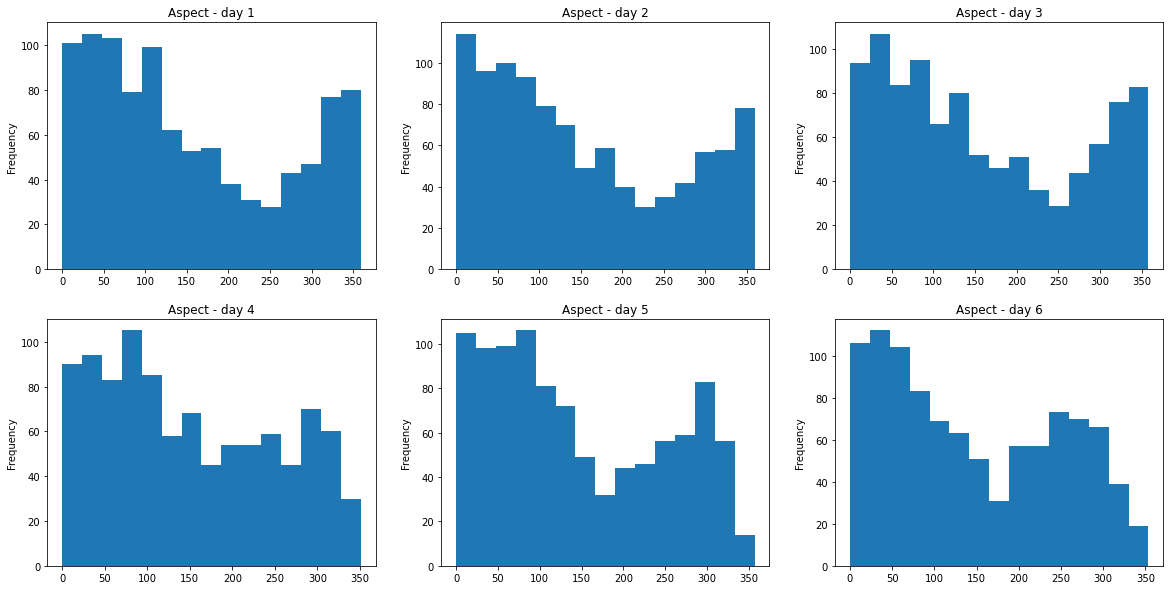

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
serving_data['2020-04-01']['Aspect'].plot.hist(bins=15, ax=axes[0, 0], title='Aspect - day 1')
serving_data['2020-04-02']['Aspect'].plot.hist(bins=15, ax=axes[0, 1], title='Aspect - day 2')
serving_data['2020-04-03']['Aspect'].plot.hist(bins=15, ax=axes[0, 2], title='Aspect - day 3')
serving_data['2020-04-04']['Aspect'].plot.hist(bins=15, ax=axes[1, 0], title='Aspect - day 4')
serving_data['2020-04-05']['Aspect'].plot.hist(bins=15, ax=axes[1, 1], title='Aspect - day 5')
serving_data['2020-04-06']['Aspect'].plot.hist(bins=15, ax=axes[1, 2], title='Aspect - day 6')

### 4.2 Skew categorical features

#### 4.2.1 Wilderness Area Feature Skew
Adding a new category "Others"


In [21]:
serving_data['2020-04-05']['Wilderness_Area'] = serving_data['2020-04-05']['Wilderness_Area'].apply(
    lambda value: 'Others' if np.random.uniform() <= 0.1 else value
)

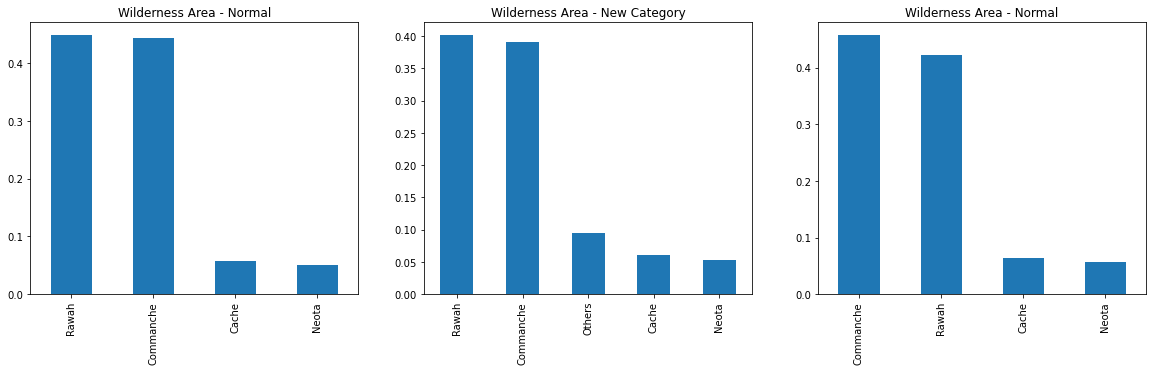

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
serving_data['2020-04-04']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0], title='Wilderness Area - Normal')
serving_data['2020-04-05']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1], title='Wilderness Area - New Category')
serving_data['2020-04-06']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[2], title='Wilderness Area - Normal')

#### 4.2.2 Wilderness Area Distribution Skew

In [23]:
serving_data['2020-04-04']['Wilderness_Area'] = serving_data['2020-04-04']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.1 else value
)

serving_data['2020-04-05']['Wilderness_Area'] = serving_data['2020-04-05']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.15 else value
)

serving_data['2020-04-06']['Wilderness_Area'] = serving_data['2020-04-06']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.2 else value
)

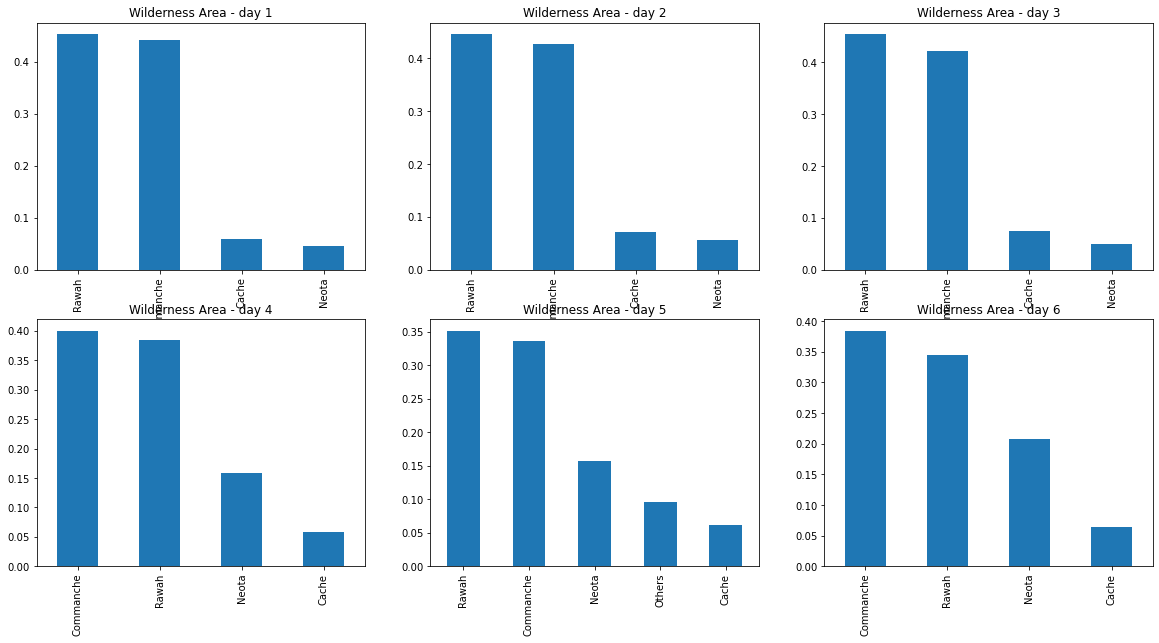

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
serving_data['2020-04-01']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 0], title='Wilderness Area - day 1')
serving_data['2020-04-02']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 1], title='Wilderness Area - day 2')
serving_data['2020-04-03']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 2], title='Wilderness Area - day 3')
serving_data['2020-04-04']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 0], title='Wilderness Area - day 4')
serving_data['2020-04-05']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 1], title='Wilderness Area - day 5')
serving_data['2020-04-06']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 2], title='Wilderness Area - day 6')


## 5. Creating schema and baseline statistics 

We will use the first serving partition - `20-04-01` - to develop schema and baseline statistics

In [25]:
from tensorflow_metadata.proto.v0 import schema_pb2, statistics_pb2
from tensorflow_data_validation import FeaturePath
from tensorflow_data_validation.utils.stats_util import get_feature_stats

### Convert all numeric features to floats

In [26]:
converted_serving_data = {}
for span in serving_data.keys():
    converted_serving_data[span] = (serving_data[span]
        .drop(['Soil_Type', 'Wilderness_Area', 'Cover_Type'], axis=1)
        .astype('float32'))

    converted_serving_data[span]['Soil_Type'] = serving_data[span]['Soil_Type'].astype('str')
    converted_serving_data[span]['Wilderness_Area'] = serving_data[span]['Wilderness_Area']

converted_serving_data['2020-04-01'].dtypes

Elevation                             float32
Aspect                                float32
Slope                                 float32
Horizontal_Distance_To_Hydrology      float32
Vertical_Distance_To_Hydrology        float32
Horizontal_Distance_To_Roadways       float32
Hillshade_9am                         float32
Hillshade_Noon                        float32
Hillshade_3pm                         float32
Horizontal_Distance_To_Fire_Points    float32
Soil_Type                              object
Wilderness_Area                        object
dtype: object

In [27]:
converted_serving_data['2020-04-01']

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area
206235,3300.0,109.0,11.0,361.0,55.0,1465.0,239.0,228.0,119.0,2259.0,7756,Commanche
288275,2588.0,115.0,9.0,150.0,7.0,474.0,236.0,232.0,127.0,1224.0,4744,Rawah
146204,3024.0,119.0,12.0,488.0,118.0,4243.0,241.0,229.0,117.0,4818.0,7745,Rawah
308572,2697.0,195.0,12.0,67.0,17.0,1533.0,218.0,250.0,164.0,3736.0,4744,Rawah
210283,3196.0,123.0,23.0,0.0,0.0,2489.0,251.0,216.0,79.0,2851.0,7745,Rawah
...,...,...,...,...,...,...,...,...,...,...,...,...
421053,2857.0,113.0,22.0,492.0,184.0,1019.0,251.0,212.0,77.0,469.0,7700,Commanche
334699,3249.0,314.0,16.0,691.0,31.0,3590.0,174.0,225.0,190.0,1256.0,7201,Commanche
342247,3114.0,28.0,23.0,666.0,89.0,1922.0,204.0,183.0,105.0,2010.0,7757,Commanche
257116,2632.0,68.0,5.0,170.0,-14.0,540.0,225.0,230.0,139.0,1648.0,4744,Rawah


### Generate statistics

In [28]:
stats = tfdv.generate_statistics_from_dataframe(converted_serving_data['2020-04-01'])

tfdv.visualize_statistics(stats)

### Auto generate schema

In [29]:
schema = tfdv.infer_schema(stats)

tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Elevation',FLOAT,required,,-
'Aspect',FLOAT,required,,-
'Slope',FLOAT,required,,-
'Horizontal_Distance_To_Hydrology',FLOAT,required,,-
'Vertical_Distance_To_Hydrology',FLOAT,required,,-
'Horizontal_Distance_To_Roadways',FLOAT,required,,-
'Hillshade_9am',FLOAT,required,,-
'Hillshade_Noon',FLOAT,required,,-
'Hillshade_3pm',FLOAT,required,,-


,Values
Domain,
'Wilderness_Area',"'Cache', 'Commanche', 'Neota', 'Rawah'"


### Fine tune the schema

In [30]:
tfdv.set_domain(schema, 'Soil_Type', schema_pb2.StringDomain(name='Soil_Type', value=[]))
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Elevation',FLOAT,required,,-
'Aspect',FLOAT,required,,-
'Slope',FLOAT,required,,-
'Horizontal_Distance_To_Hydrology',FLOAT,required,,-
'Vertical_Distance_To_Hydrology',FLOAT,required,,-
'Horizontal_Distance_To_Roadways',FLOAT,required,,-
'Hillshade_9am',FLOAT,required,,-
'Hillshade_Noon',FLOAT,required,,-
'Hillshade_3pm',FLOAT,required,,-


,Values
Domain,
'Wilderness_Area',"'Cache', 'Commanche', 'Neota', 'Rawah'"
'Soil_Type',


In [31]:
stats_options = tfdv.StatsOptions(schema=schema, infer_type_from_schema=True)
stats = tfdv.generate_statistics_from_dataframe(converted_serving_data['2020-04-01'], stats_options)

feature_path = FeaturePath(['Soil_Type'])
feature_stats = get_feature_stats(stats.datasets[0], feature_path)

soil_type_domain = [bucket.label for bucket in feature_stats.string_stats.rank_histogram.buckets]
soil_type_domain

['7745',
 '7202',
 '7757',
 '7756',
 '7201',
 '4744',
 '4703',
 '7746',
 '7755',
 '7700',
 '8771',
 '4704',
 '4758',
 '8772',
 '2703',
 '2705',
 '7102',
 '8776',
 '2717',
 '6102',
 '2704',
 '8703',
 '7790',
 '7101',
 '2702',
 '6101',
 '7702',
 '7103',
 '6731',
 '8707',
 '7709',
 '7701',
 '5101',
 '4201',
 '2706']

In [32]:
tfdv.set_domain(schema, 'Soil_Type', schema_pb2.StringDomain(name='Soil_Type', value=soil_type_domain))
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Elevation',FLOAT,required,,-
'Aspect',FLOAT,required,,-
'Slope',FLOAT,required,,-
'Horizontal_Distance_To_Hydrology',FLOAT,required,,-
'Vertical_Distance_To_Hydrology',FLOAT,required,,-
'Horizontal_Distance_To_Roadways',FLOAT,required,,-
'Hillshade_9am',FLOAT,required,,-
'Hillshade_Noon',FLOAT,required,,-
'Hillshade_3pm',FLOAT,required,,-


,Values
Domain,
'Wilderness_Area',"'Cache', 'Commanche', 'Neota', 'Rawah'"
'Soil_Type',"'7745', '7202', '7757', '7756', '7201', '4744', '4703', '7746', '7755', '7700', '8771', '4704', '4758', '8772', '2703', '2705', '7102', '8776', '2717', '6102', '2704', '8703', '7790', '7101', '2702', '6101', '7702', '7103', '6731', '8707', '7709', '7701', '5101', '4201', '2706'"


### Save baseline stats and schema to GCS

In [33]:
schema_file = LOCAL_SCHEMA_DIR + '/schema.pbtxt'
stats_file = LOCAL_BASELINE_STATS_DIR + '/stats.pbtxt'

tfdv.write_schema_text(schema, schema_file)
tfdv.write_stats_text(stats, stats_file)

!gsutil cp {schema_file} {GCS_SCHEMA_LOCATION}/
!gsutil cp {stats_file} {GCS_BASELINE_STATS_LOCATION}/

!gsutil ls {GCS_SCHEMA_LOCATION}
!gsutil ls {GCS_BASELINE_STATS_LOCATION}

Copying file://./data_staging/schema/schema.pbtxt [Content-Type=application/octet-stream]...

Operation completed over 1 objects/2.6 KiB.                                      
Copying file://./data_staging/baseline_stats/stats.pbtxt [Content-Type=application/octet-stream]...

Operation completed over 1 objects/49.7 KiB.                                     
gs://mlops-dev-workspace/drift-monitor/schema/schema.pbtxt
gs://mlops-dev-workspace/drift-monitor/baseline_stats/stats.pbtxt


## 6. Simulating serving workload

In [37]:
from generate_predict_tasks import create_predict_task
from datetime import datetime
from datetime import timedelta

In [38]:
start_time = datetime.fromisoformat('2020-06-03T17:00:00')

project = 'mlops-dev-env'
location = 'us-central1'
queue =  'caip-player'
model_name = 'covertype_tf'
model_version = 'v3'
service_account = "caipp-caller@mlops-dev-env.iam.gserviceaccount.com"
instances_per_call = 2
seconds_between_calls = 4


In [39]:
count = 0
for span in converted_serving_data.keys():
    feature_dicts = converted_serving_data[span].to_dict(orient='record')
    instances = []
    execute_time = start_time
    for feature_dict in feature_dicts:
        feature_dict = {name: [value] for name, value in feature_dict.items()}
        instances.append(feature_dict)
        if len(instances) == instances_per_call:
            execute_time = execute_time + timedelta(seconds = seconds_between_calls)
            response = create_predict_task(
                project=project,
                queue=queue,
                service_account=service_account,
                location=location,
                model_name=model_name,
                model_version=model_version,
                instances=instances,
                execute_time=execute_time)
            instances = []
            count += 1
            if count % 100 == 0:
                print('Scheduled {} tasks'.format(count))
    start_time = start_time + timedelta(minutes=60)


Scheduled 100 tasks
Scheduled 200 tasks
Scheduled 300 tasks
Scheduled 400 tasks
Scheduled 500 tasks
Scheduled 600 tasks
Scheduled 700 tasks
Scheduled 800 tasks
Scheduled 900 tasks
Scheduled 1000 tasks
Scheduled 1100 tasks
Scheduled 1200 tasks
Scheduled 1300 tasks
Scheduled 1400 tasks
Scheduled 1500 tasks
Scheduled 1600 tasks
Scheduled 1700 tasks
Scheduled 1800 tasks
Scheduled 1900 tasks
Scheduled 2000 tasks
Scheduled 2100 tasks
Scheduled 2200 tasks
Scheduled 2300 tasks
Scheduled 2400 tasks
Scheduled 2500 tasks
Scheduled 2600 tasks
Scheduled 2700 tasks
Scheduled 2800 tasks
Scheduled 2900 tasks
Scheduled 3000 tasks
